# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta
from matplotlib import pyplot as plt
import re

import pickle as pkls
import sims_copy

sns.set_style("darkgrid")
import os

# Load the Data

In [2]:
# SIMULATION PARAMETERS AGNOSTIC TO DATA
"""Variables needed in the next cell
"""
T = 6           # max number of timesteps
M = 100000            # size of unit mass


pi,beta_dist,P,v,c,q = sims_copy.get_params('facebook')

#theta_hat and theta_tilde learned with T = 15, epsilon = 0.05
#since the optimization in the following cell only needs to be run once per set of parameters

#T = 14, epsilon = 1e-4
theta_fair = {1: 0.0, -1: 0.810973068866342}
theta_opt = {1: 4.316992360088821e-11, -1: 0.9999999999745947}
theta_half = {1: 0.5, -1: 0.5}

#T = 12, epsilon = 1e-10
theta_fair = {1: 0.0, -1: 0.8248699654379131}
theta_opt ={1: 4.2866804763043903e-11, -1: 0.9999999999746445}
theta_half = {1: 0.5, -1: 0.5}

#T = 14, epsilon = 1e-10
theta_fair = {1: 0.0, -1: 0.8109288469677634}
theta_opt = {1: 4.316992360088821e-11, -1: 0.9999999999745947}
theta_half = {1: 0.5, -1: 0.5}

In [3]:
#run the experiments multiple times for paper results
"""Changes from analysis.ipnyb based off what's returned in sim_copy

"""
num_trials = 25

players_list_fair = []
group_one_player_fair = []
shown_fair = []
click_fair = []
share_fair = []
pof_fair = []

players_list_opt = []
group_one_player_opt = []
shown_opt = []
click_opt = []
share_opt = []
pof_opt = []

players_list_half = []
group_one_player_half = []
shown_half = []
click_half = []
share_half = []
pof_half = []

for i in range(num_trials):
    #players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = sims.runModel(theta_fair, T, pi, M, P, beta_dist, v,c,q)
    players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair, group_one_fair = sims_copy.runModel(theta_fair, T, pi, M, P, beta_dist, v,c,q)
    players_in_model_opt, shown_d_opt, click_d_opt, share_d_opt, group_one_opt  = sims_copy.runModel(theta_opt, T, pi, M, P, beta_dist, v,c,q)
    players_in_model_half, shown_d_half, click_d_half, share_d_half, group_one_half  = sims_copy.runModel(theta_half, T, pi, M, P, beta_dist, v,c,q)
    
    players_list_fair.append(players_in_model_fair + ([0] * (T - len(players_in_model_fair))))
    shown_fair.append(shown_d_fair)
    click_fair.append(click_d_fair)
    share_fair.append(share_d_fair)
    group_one_player_fair.append(group_one_fair)
    pof_fair.append(sum(players_in_model_fair[1:]))
    
    players_list_opt.append(players_in_model_opt + ([0] * (T - len(players_in_model_opt))))
    shown_opt.append(shown_d_opt)
    click_opt.append(click_d_opt)
    share_opt.append(share_d_opt)
    group_one_player_opt.append(group_one_opt)
    pof_opt.append(sum(players_in_model_opt[1:]))
    
    
    players_list_half.append(players_in_model_half + ([0] * (T - len(players_in_model_half))))
    shown_half.append(shown_d_half)
    click_half.append(click_d_half)
    share_half.append(share_d_half)
    group_one_player_half.append(group_one_half)
    pof_half.append(sum(players_in_model_half[1:]))


In [4]:
#pickle the data if needed
sims_copy.saveRuns(players_list_fair, 'simulation_data/players_list_fair.pkl')
sims_copy.saveRuns(shown_fair, 'simulation_data/shown_fair.pkl')
sims_copy.saveRuns(click_fair, 'simulation_data/click_fair.pkl')
sims_copy.saveRuns(share_fair, 'simulation_data/share_fair.pkl')
sims_copy.saveRuns(pof_fair, 'simulation_data/pof_fair.pkl')
sims_copy.saveRuns(group_one_player_fair, 'simulation_data/group_one_player_fair.pkl')


sims_copy.saveRuns(players_list_opt, 'simulation_data/players_list_opt.pkl')
sims_copy.saveRuns(shown_opt, 'simulation_data/shown_opt.pkl')
sims_copy.saveRuns(click_opt, 'simulation_data/click_opt.pkl')
sims_copy.saveRuns(share_opt, 'simulation_data/share_opt.pkl')
sims_copy.saveRuns(pof_opt, 'simulation_data/pof_opt.pkl')
sims_copy.saveRuns(group_one_player_opt, 'simulation_data/group_one_player_opt.pkl')

sims_copy.saveRuns(players_list_half, 'simulation_data/players_list_half.pkl')
sims_copy.saveRuns(shown_half, 'simulation_data/shown_half.pkl')
sims_copy.saveRuns(click_half, 'simulation_data/click_half.pkl')
sims_copy.saveRuns(share_half, 'simulation_data/share_half.pkl')
sims_copy.saveRuns(pof_half, 'simulation_data/pof_half.pkl')
sims_copy.saveRuns(group_one_player_half, 'simulation_data/group_one_player_half.pkl')

# Data Prep

In [5]:
def percentage(df):
    dd = df.iloc[:, 1:]
    df_temp = dd[dd.columns].div(dd[dd.columns].sum(axis=1), axis=0).multiply(100)
    df.iloc[:, 1:] = df_temp.round(2)
    return df

def create_cs_df(data):
    """
    This data cleaning applies to click_fair, click_opt, click_half
    and shown_fair, shown_opt, shown_half and share
    
    """
    data_dp = pd.DataFrame.from_dict(data)
    data_dp["Time Step"] = data_dp.index
    data_dp["A"] = data_dp[(1, 1)] + data_dp[(-1, 1)]
    data_dp["B"] = data_dp[(1, -1)] + data_dp[(-1, -1)]
    data_dp["Aa"] = data_dp[(1, 1)]
    data_dp["Ab"] = data_dp[(-1, 1)]
    data_dp["Bb"] = data_dp[(-1, -1)]
    data_dp["Ba"] = data_dp[(1, -1)]
    data_df = data_dp.iloc[:, 4:] 
    return data_df


def new_css_df(df):
    data_dp = pd.DataFrame()
    Aa = []
    Ab = []
    Ba = []
    Bb = []
    t = []
    
    for j in range(0, max(map(len, df))):
        Aa.append(np.mean((([(i[j].get((1, 1))) if j < len(i) else 0 for i in df]))))
        Ab.append(np.mean((([(i[j].get((-1, 1))) if j < len(i) else 0 for i in df]))))
        Ba.append(np.mean((([(i[j].get((1, -1))) if j < len(i) else 0 for i in df]))))
        Bb.append(np.mean((([(i[j].get((-1, -1))) if j < len(i) else 0 for i in df]))))
        t.append(j)
    
    data_dp["Time Step"] = t
    data_dp["Aa"] = Aa
    data_dp["Ab"] = Ab
    data_dp["Bb"] = Bb
    data_dp["Ba"] = Ba
    data_dp["A"] = data_dp["Aa"] + data_dp["Ab"]
    data_dp["B"] = data_dp["Ba"] + data_dp["Bb"]

    return data_dp


def df_melt_A_B(data, val_name, n):
    """
    n: control for number of rows
    """
    data_dp = new_css_df(data) #create_cs_df(data)
    data_df = data_dp[["Time Step", "A", "B"]].iloc[:n, :]
    data_df = data_df.melt('Time Step', var_name='Viewer Membership',  value_name=val_name)
    return data_df
    

def df_melt_inter_intra(data, val_name, n):
    """
    n: control for number of rows
    """
    data_dp = new_css_df(data) #create_cs_df(data)
    columns = ["Time Step", "Aa", "Ab", "Bb", "Ba"]
    data_dp = data_dp[columns]
    data_df = data_dp.iloc[0:n, :]
    data_df = data_df.melt('Time Step', var_name='Viewer/Article Membership',  value_name=val_name)
    return data_df


#### Try here before creating functions

In [6]:
click_fair[0][0]

{(1, 1): 14208, (-1, 1): 3998, (1, -1): 6893, (-1, -1): 10193}

In [7]:
click_fair[1][0]

{(1, 1): 14085, (-1, 1): 4030, (1, -1): 6899, (-1, -1): 10253}

In [8]:
len(click_fair[0])

5

In [9]:
click_fair[0][0]

{(1, 1): 14208, (-1, 1): 3998, (1, -1): 6893, (-1, -1): 10193}

In [10]:
len(click_fair[5])

5

In [11]:
new_css_df(click_fair)

,Time Step,Aa,Ab,Bb,Ba,A,B
0,0,14178.56,3988.76,10306.20,6872.72,18167.32,17178.92
1,1,3798.08,1316.36,2916.56,1939.32,5114.44,4855.88
2,2,1395.96,460.24,957.28,705.48,1856.20,1662.76
3,3,616.80,177.56,361.32,299.84,794.36,661.16
4,4,304.48,73.88,161.00,155.08,378.36,316.08


In [12]:
ff = new_css_df(click_fair)
ff[["Time Step", "A", "B"]].iloc[:3, :]

,Time Step,A,B
0,0,18167.32,17178.92
1,1,5114.44,4855.88
2,2,1856.20,1662.76


In [13]:
df = create_cs_df(click_fair[20])

In [14]:
columns = ["Time Step", "Aa", "Ab", "Bb", "Ba"]
dff = df[columns]
dff

,Time Step,Aa,Ab,Bb,Ba
0,0,14255,4039,10278,6860
1,1,950,1028,2603,555
2,2,57,254,653,38
3,3,2,67,178,1
4,4,0,18,49,0


In [15]:
players_list_fair[0]

[100000, 35292, 10329, 2975, 847, 221]

In [16]:
players_list_fair[20]

[100000, 35432, 5136, 1002, 248, 67]

In [17]:
np.mean(players_list_fair, axis=0)

array([100000.  ,  35346.24,   9970.32,   3518.96,   1455.52,    694.44])

# Plots

In [18]:

def plot_cs_A_B(data, name, grouping):
    
    dire= 'figures/'
    if not os.path.exists(dire):
        os.makedirs(dire)
        
    if name == 'click':
        val_name = 'Number of Clicks'
        title = "Click Rate"
    elif name == 'shown':
        val_name = 'Shown Count'
        title = 'Shown'
    else:
        val_name = 'Share Count'
        title = 'Share'
    
    n_rows = 30
    
    if grouping == "inter/intra":
        data_df = df_melt_inter_intra(data, val_name, n_rows)
        val = "Viewer/Article Membership"
        na = name+'_inter_intra'
    else:
        data_df = df_melt_A_B(data, val_name, n_rows)
        val = 'Viewer Membership'
        na = name+'_all'
        
    g = sns.factorplot(x="Time Step", y=val_name, hue=val, data=data_df, \
                      height=6, aspect=8/6)
    g.savefig(dire+na+".png", bbox_inches='tight')
    
    
def plot_cs_A_B_all(data1, data2, data3, name, grouping, n_rows):
    dire = 'figures/'
    if not os.path.exists(dire):
        os.makedirs(dire)
        
    if name == 'click':
        val_name = 'Number of Clicks'
        title = "#Clicks"
    elif name == 'shown':
        val_name = 'Shown Count'
        title = '#Shown'
    else:
        val_name = 'Share Count'
        title = '#Share'

    
    if grouping == "inter/intra":
        data_df1 = df_melt_inter_intra(data1, val_name, n_rows)
        data_df2 = df_melt_inter_intra(data2, val_name, n_rows)
        data_df3 = df_melt_inter_intra(data3, val_name, n_rows)
        val = "Viewer/Article Membership"
        na = name+'_inter_intra'
    else:
        data_df1 = df_melt_A_B(data1, val_name, n_rows)
        data_df2 = df_melt_A_B(data2, val_name, n_rows)
        data_df3 = df_melt_A_B(data3, val_name, n_rows)
        val = 'Viewer Membership'
        na = name+'_all'


    fig, axs = plt.subplots(figsize=(21, 5), ncols=3, constrained_layout=True)
    
    'Exposure-constrained $\hat \\theta$', 'Unconstrained $\\tilde \\theta$',\
            'Half-exposure $\\theta_g = 1/2$'

    sns.lineplot(x="Time Step", y=val_name, hue=val, data=data_df1,\
                 marker="o", ax=axs[0])
    axs[0].set_title(title+" when Exposure-constrained $\hat \\theta$") #optimal
    # axs[0].set_xticklabels(np.arange(1.0, float(T), 0.5))
    axs[0].set_yscale('log')
    sns.lineplot(x="Time Step", y=val_name, hue=val, data=data_df2,\
                 marker="o", ax=axs[1])
    axs[1].set_title(title+" when Unconstrained $\\tilde \\theta$") #fair
    # axs[1].set_xticklabels(np.arange(1.0, float(T), 0.5))
    axs[1].set_yscale('log')
    sns.lineplot(x="Time Step", y=val_name, hue=val, data=data_df3,\
                 marker="o", ax=axs[2])
    axs[2].set_title(title+" when Half-exposure $\\theta_g = 1/2$")  #half
    axs[2].set_yscale('log')
    # axs[2].set_xticklabels(np.arange(1.0, float(T), 0.5))
    fig.savefig(dire+na+".png", bbox_inches='tight')
    plt.show();
    


def shown_share_click(nrows):
    
    dire = 'figures/'
    if not os.path.exists(dire):
        os.makedirs(dire)
        
    sns.set(style="white")
    val_name1 = 'Number of Clicks'
    val_name2 = 'Shown Count'
    val_name3 = 'Share Count'

    title = "Click rate vs. Shown vs. Share"

    data_df11 = df_melt_A_B(click_opt, val_name1, nrows)
    data_df12 = df_melt_A_B(click_fair, val_name1, nrows)
    data_df13 = df_melt_A_B(click_half, val_name1, nrows)

    data_df21 = df_melt_A_B(shown_opt, val_name2, nrows)
    data_df22 = df_melt_A_B(shown_fair, val_name2, nrows)
    data_df23 = df_melt_A_B(shown_half, val_name2, nrows)

    data_df31 = df_melt_A_B(share_opt, val_name3, nrows)
    data_df32 = df_melt_A_B(share_fair, val_name3, nrows)
    data_df33 = df_melt_A_B(share_half, val_name3, nrows)


    fig, axs = plt.subplots(figsize=(21, 5), ncols=3, constrained_layout=True)
    sns.lineplot(x="Time Step", y=val_name1, hue='Viewer Membership', style='Viewer Membership', data=data_df11,\
                 marker="o", palette=['green', 'black'], linewidth=1.5, ax=axs[0]) # click
    sns.barplot(x="Time Step", y=val_name2, hue='Viewer Membership', data=data_df21, palette="rocket", ax=axs[0])
    # show
    sns.barplot(x="Time Step", y=val_name3, hue='Viewer Membership', data=data_df31, ax=axs[0]) # share
    # axs[0].set_xticklabels(np.arange(1.0, float(T), 0.5))
    axs[0].set_yscale('log')
    axs[0].set_title(title+" when Exposure-constrained $\hat \\theta$") #optimal
    axs[0].set_ylabel("")


    sns.lineplot(x="Time Step", y=val_name1, hue='Viewer Membership', style='Viewer Membership', data=data_df12,\
                 marker="o", palette=['green', 'black'], linewidth=1.5, ax=axs[1]) # click
    sns.barplot(x="Time Step", y=val_name2, hue='Viewer Membership', data=data_df22, palette="rocket", ax=axs[1])
    # show
    sns.barplot(x="Time Step", y=val_name3, hue='Viewer Membership', data=data_df32, ax=axs[1]) # share
    # axs[1].set_xticklabels(np.arange(1.0, float(T), 0.5))
    axs[1].set_yscale('log')
    axs[1].set_title(title+" when Unconstrained $\\tilde \\theta$") #fair
    axs[1].set_ylabel("")


    sns.lineplot(x="Time Step", y=val_name1, hue='Viewer Membership', style='Viewer Membership', data=data_df13,\
                 marker="o", palette=['green', 'black'], linewidth=1.5, ax=axs[2]) # click
    sns.barplot(x="Time Step", y=val_name2, hue='Viewer Membership', data=data_df23, palette="rocket", ax=axs[2])
    # show
    sns.barplot(x="Time Step", y=val_name3, hue='Viewer Membership', data=data_df33, ax=axs[2]) # share
    # axs[2].set_xticklabels(np.arange(1.0, float(T), 0.5))
    axs[2].set_yscale('log')
    axs[2].set_title(title+" when Half-exposure $\\theta_g = 1/2$")  #half
    axs[2].set_ylabel("")

    plt.savefig(dire+'shown_share_click.png', bbox_inches='tight')
    plt.show();



# Visuals

## Clicks

### Test to see how any looks Individually

- Click Fair
- Click Opt
- Click Half

### A and B collectively 

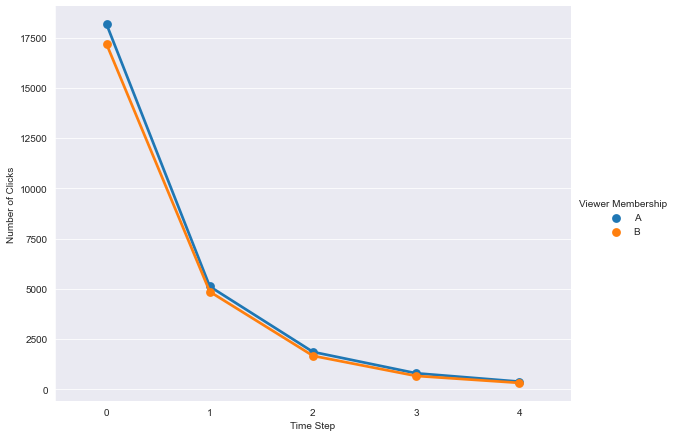

In [19]:
click_fair_dp = new_css_df(click_fair)
plot_cs_A_B(click_fair, 'click', 'all')

### Inter / Intra propagation

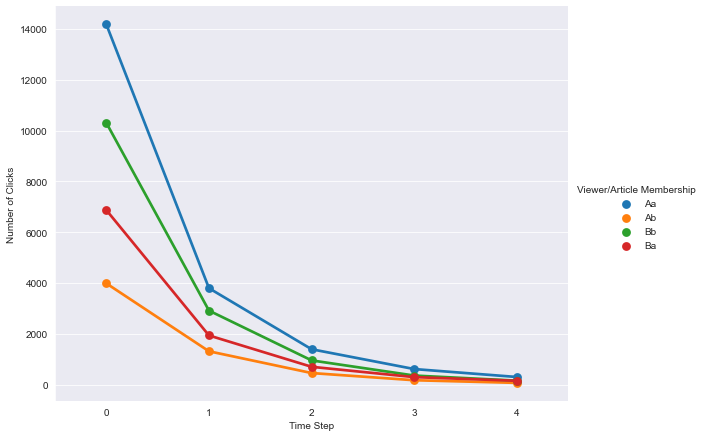

In [20]:
plot_cs_A_B(click_fair, 'click', 'inter/intra')

### All: A and B 

- Compare the different click rates against each other on one row

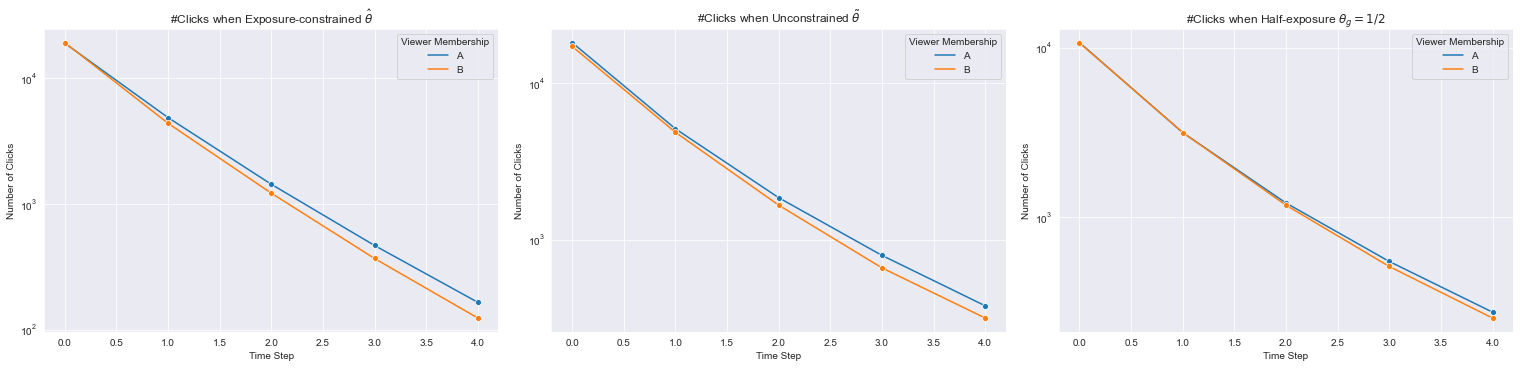

In [21]:
plot_cs_A_B_all(click_opt, click_fair, click_half,'click', 'all', T)

### All: Inter/Intra propagation

- Compare the different click rates against each other on one row

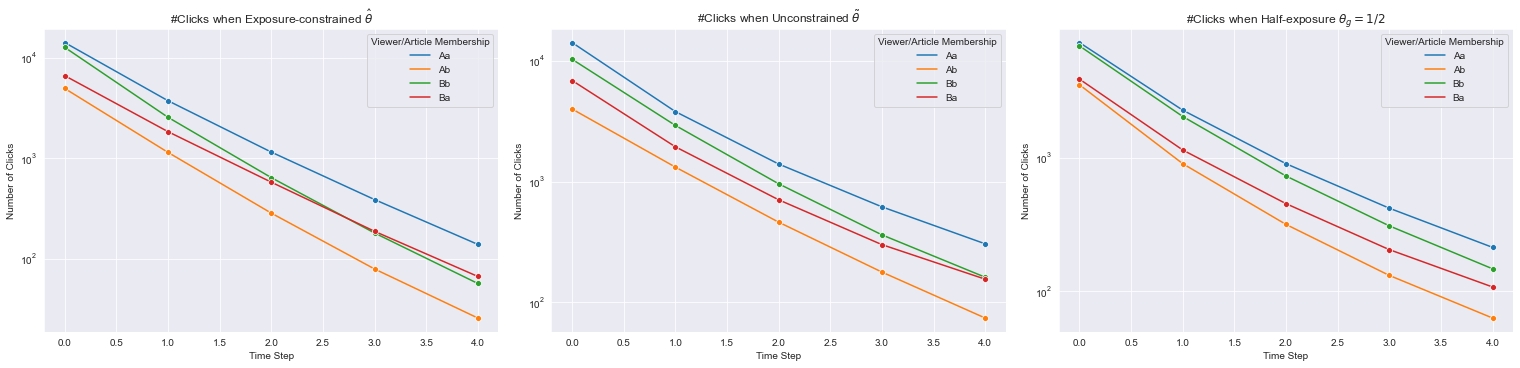

In [22]:
plot_cs_A_B_all(click_opt, click_fair, click_half,'click', 'inter/intra', T)

## Shown

### Test to see how any looks Individually

- Shown Fair
- Shown Opt
- Shown Half

### A and B collectively 

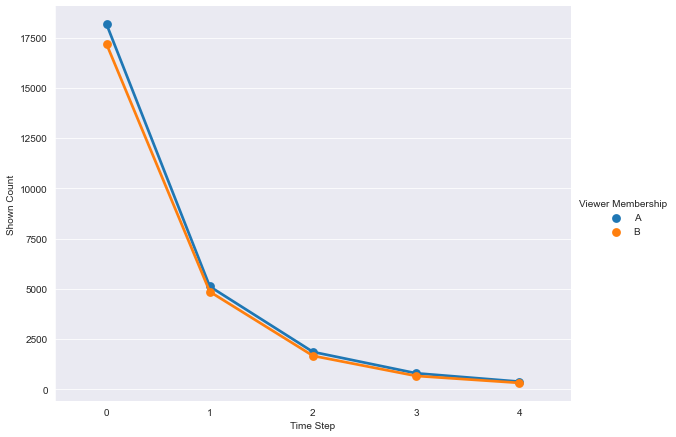

In [23]:
shown_fair_dp = new_css_df(shown_fair)
plot_cs_A_B(shown_fair, 'shown', 'all')

### Inter/Intra propagation

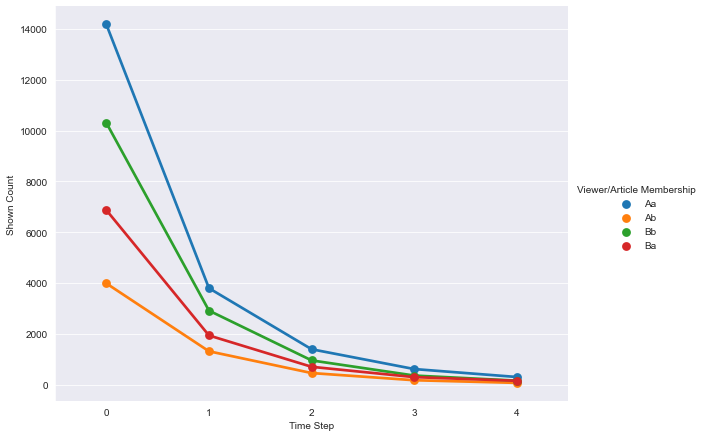

In [24]:
plot_cs_A_B(shown_fair, 'shown', 'inter/intra')

### All: A and B 

- Compare the different showns against each other on one row

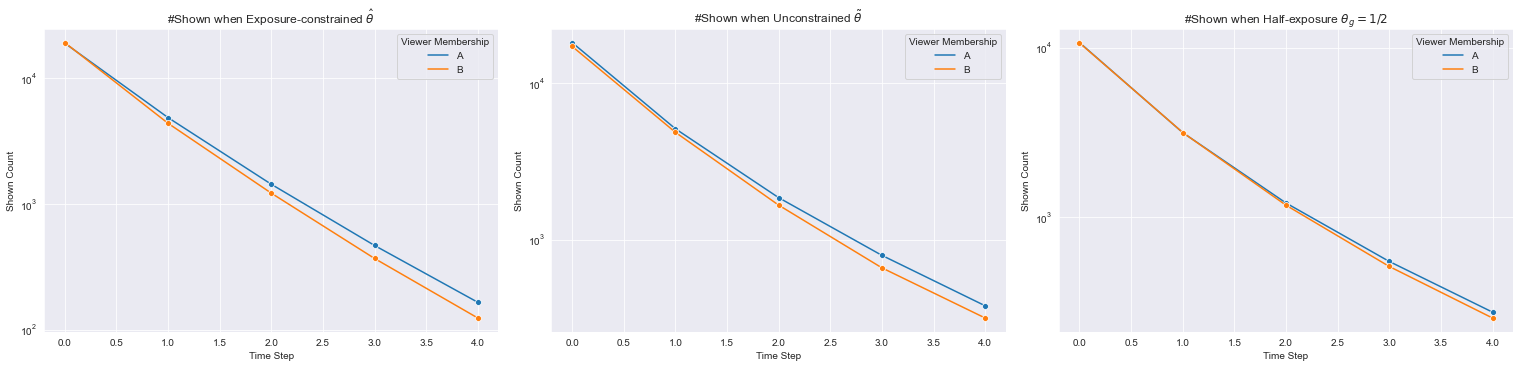

In [25]:
plot_cs_A_B_all(shown_opt, shown_fair, shown_half,'shown', all, T)

### All: Inter/Intra propagation

- Compare the different showns against each other on one row

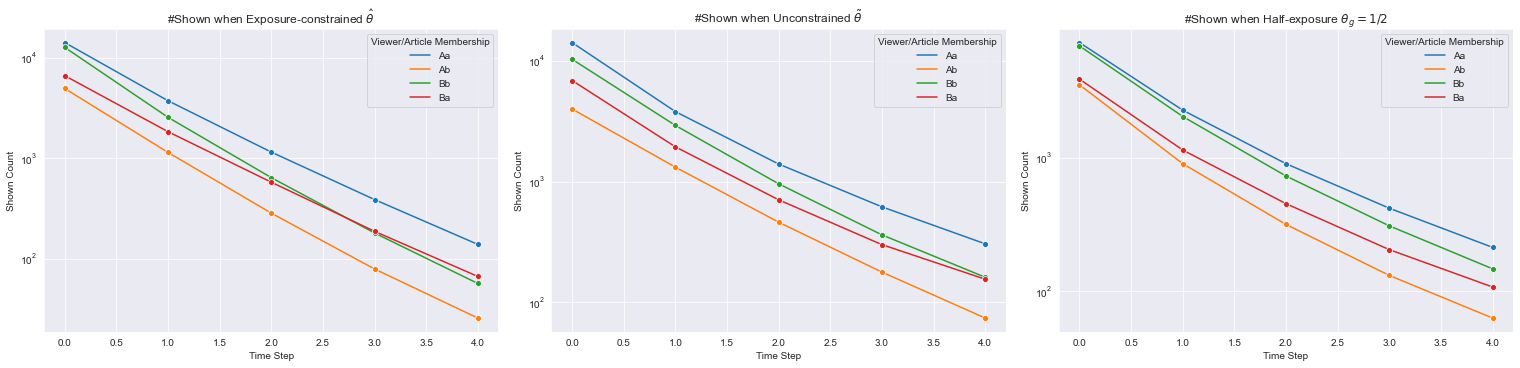

In [26]:
plot_cs_A_B_all(shown_opt, shown_fair, shown_half,'shown', 'inter/intra', T)

## Shares 

### Test to see how any looks Individually

- Share Fair
- Share Opt
- Share Half

### A and B collectively 

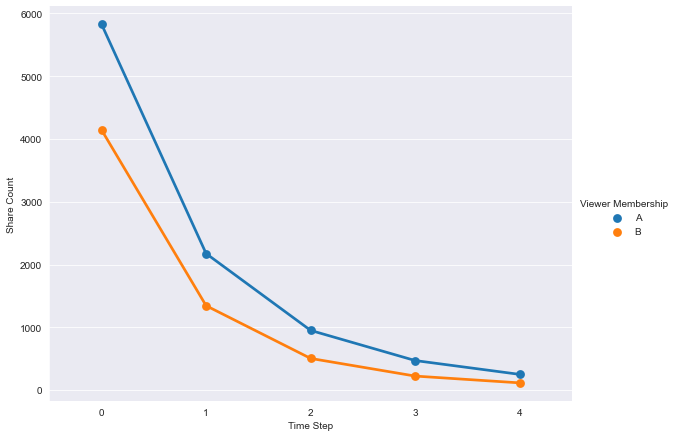

In [27]:
share_fair_dp = new_css_df(share_fair)
plot_cs_A_B(share_fair, 'share', 'all')

### Inter/Intra propagation

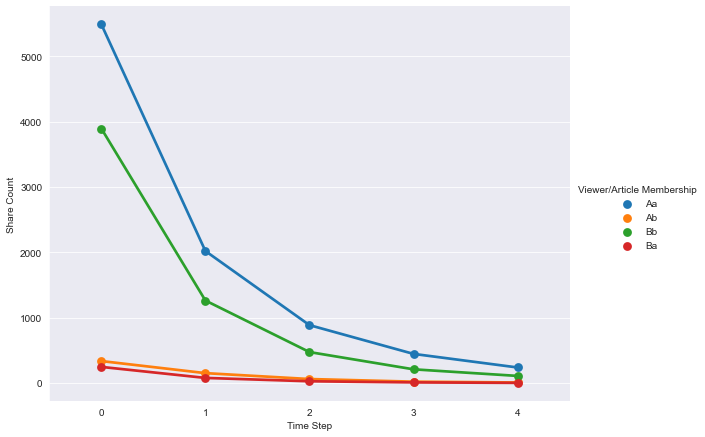

In [28]:
plot_cs_A_B(share_fair, 'share', 'inter/intra')

### All: A and B 

- Compare the different shares against each other on one row

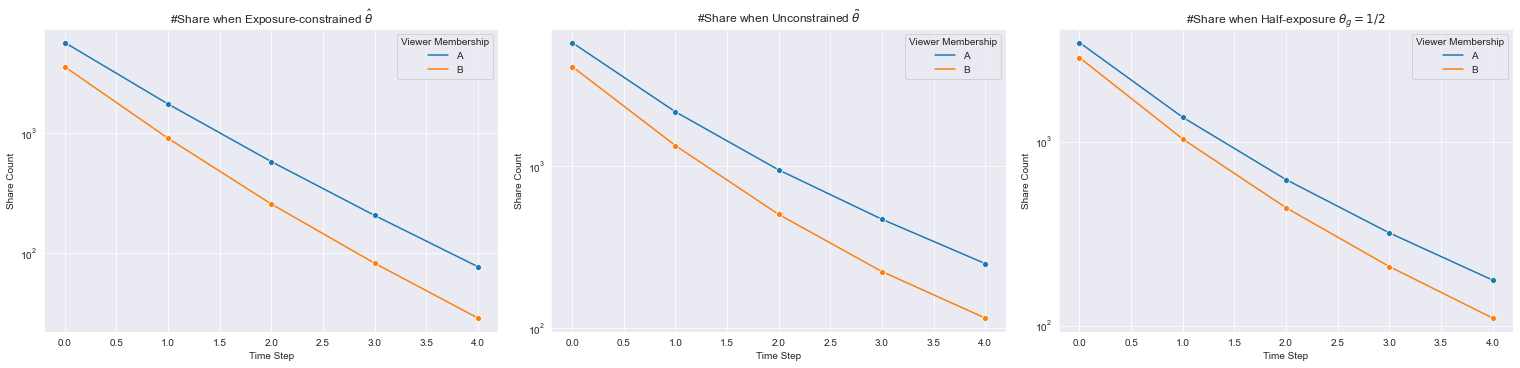

In [29]:
plot_cs_A_B_all(share_opt, share_fair, share_half,'share', 'all', T)


### All: Inter/Intra propagation

- Compare the different shares against each other on one row

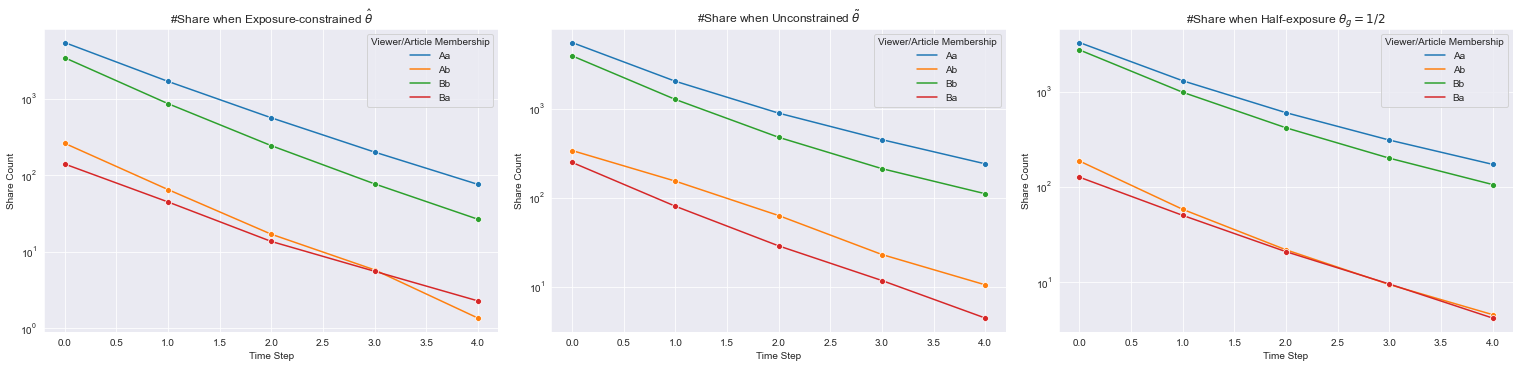

In [30]:
plot_cs_A_B_all(share_opt, share_fair, share_half,'share', 'inter/intra', T)

# Shown vs Click Rate vs Shares

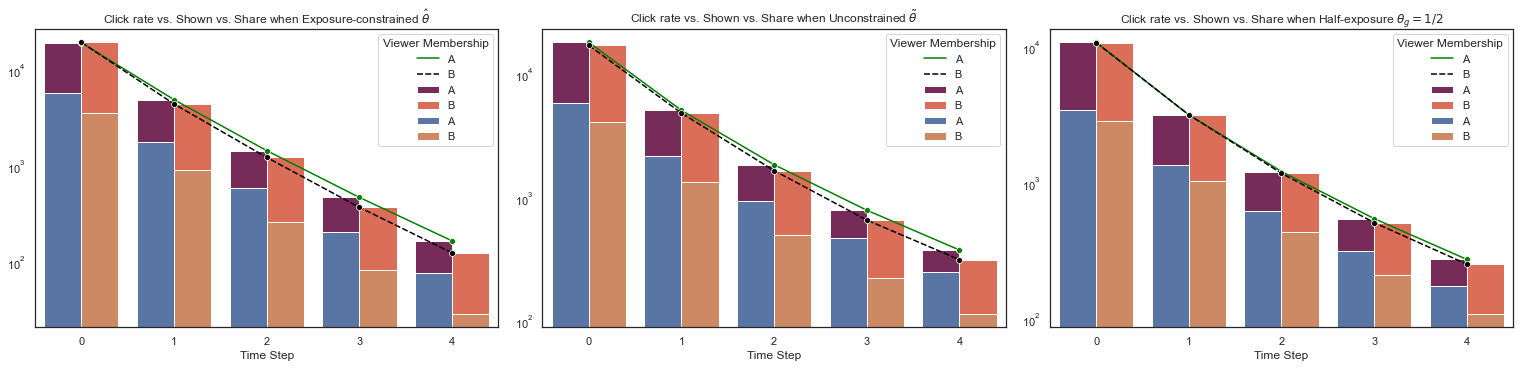

In [31]:
shown_share_click(T)

# Viewers / Players

In [32]:
"""Extracted from analysis with minor changes"""

'Extracted from analysis with minor changes'

In [37]:
playes_fair = np.mean(players_list_fair, axis=0)
playes_opt = np.mean(players_list_opt, axis=0)
playes_half =  np.mean(players_list_opt, axis=0)

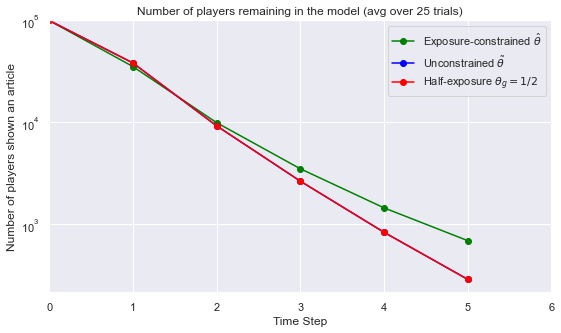

In [38]:
dire = 'figures/'
if not os.path.exists(dire):
    os.makedirs(dire)
sns.set_style("darkgrid")

plt.figure(figsize=(9,5))
plt.plot(playes_fair, color='green', marker="o")
plt.plot(playes_opt,  color='blue', marker="o")
plt.plot(playes_half, color='red', marker="o")
plt.title("Number of players remaining in the model (avg over %i trials)" % (num_trials))
plt.ylabel("Number of players shown an article")
plt.xlabel("Time Step")
plt.yscale('log')
plt.xlim((0,T))
plt.ylim((0, M))
plt.legend(('Exposure-constrained $\hat \\theta$', 'Unconstrained $\\tilde \\theta$',\
            'Half-exposure $\\theta_g = 1/2$'))
plt.savefig(dire+"number_players.png")
plt.show()

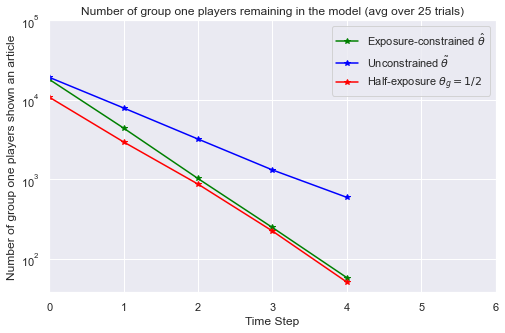

In [39]:
dire = 'figures/'
if not os.path.exists(dire):
    os.makedirs(dire)
sns.set_style("darkgrid")

plt.figure(figsize=(8,5))
plt.plot(group_one_player_fair[10], color='green', marker="*")
plt.plot(group_one_player_opt[10],  color='blue', marker="*")
plt.plot(group_one_player_half[10], color='red', marker="*")
plt.title("Number of group one players remaining in the model (avg over %i trials)" % (num_trials))
plt.ylabel("Number of group one players shown an article")
plt.xlabel("Time Step")
plt.yscale('log')
plt.xlim((0,T))
plt.ylim((0, M))
plt.legend(('Exposure-constrained $\hat \\theta$', 'Unconstrained $\\tilde \\theta$',\
            'Half-exposure $\\theta_g = 1/2$'))
plt.savefig(dire+"number_group_one_players.png")
plt.show()